<a href="https://colab.research.google.com/github/lenkalapellypraveen/Automated-Brain-Tumor-Segmentation-and-Detection-Using-Deep-Neural-Networks-on-FLAIR-MRI/blob/dev/BrainTumorDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import numpy as np

In [ ]:
pip install nibabel

In [ ]:
# Mounting Google drive
import nibabel as nib
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Replacing path to the BRATS dataset folder
data_folder = "/content/drive/MyDrive/ML_data/Task01_BrainTumour"

# Crop height and width to this size
crop_dim=128
batch_size = 128
seed=816

# Train/Test aplit
train_test_split=0.80

In [ ]:
from tensorflow.keras.utils import Sequence
import numpy as np
import os
import json
import nibabel as nib

def get_decathlon_filelist(data_folder, seed=816, split=0.85):
    # Get the paths for the original decathlon files
    json_filename = os.path.join(data_folder, "dataset.json")
    try:
        with open(json_filename, "r") as fp:
            experiment_data = json.load(fp)
    except IOError as e:
        raise Exception("File {} doesn't exist. It should be part of the "
              "Decathlon directory".format(json_filename))

    # Print information about the Decathlon experiment data
    print("*" * 30)
    print("=" * 30)
    print(f'Dataset name :        {experiment_data["name"]}')
    print(f'Dataset description:  {experiment_data["description"]}')
    print(f'Tensor image size:    {experiment_data["tensorImageSize"]}')
    print(f'Dataset release:      {experiment_data["release"]}')
    print(f'Dataset reference:    {experiment_data["reference"]}')
    print(f'Dataset license:      {experiment_data["licence"]}')
    print("=" * 30)
    print("*" * 30)

    # Set the random seed so that always get same random mix
    np.random.seed(seed)
    numFiles = experiment_data["numTraining"]

    # List of file indices
    idxList = np.arange(numFiles)

    # Shuffle the indices to randomize train/test/split
    np.random.shuffle(idxList)

    # index for the end of the training files
    trainIdx = int(np.floor(numFiles*split))
    trainList = idxList[:trainIdx]

    otherList = idxList[trainIdx:]
    numOther = len(otherList)

    # index for the end of the testing files
    otherIdx = numOther//2
    validateList = otherList[:otherIdx]
    testList = otherList[otherIdx:]

    trainFiles = []
    for idx in trainList:
        trainFiles.append(os.path.join(data_folder, experiment_data["training"][idx]["label"]))

    validateFiles = []
    for idx in validateList:
        validateFiles.append(os.path.join(data_folder, experiment_data["training"][idx]["label"]))

    testFiles = []
    for idx in testList:
        testFiles.append(os.path.join(data_folder, experiment_data["training"][idx]["label"]))

    print(f'Number of training files   = {len(trainList)}')
    print(f'Number of validation files = {len(validateList)}')
    print(f'Number of testing files    = {len(testList)}')

    return trainFiles, validateFiles, testFiles


class DatasetGenerator(Sequence):
    def __init__(self, filenames, batch_size=8, crop_dim=[240,240], augment=False, seed=816):
        # Load the first image
        img = np.array(nib.load(filenames[0]).dataobj)

        # assume z-dimension (slice) is last
        self.slice_dim = 2

        # Determine the number of slices
        self.num_slices_per_scan = img.shape[self.slice_dim]

        # If crop_dim == -1, then don't crop
        if crop_dim[0] == -1:
            crop_dim[0] = img.shape[0]
        if crop_dim[1] == -1:
            crop_dim[1] = img.shape[1]
        self.crop_dim = crop_dim

        self.filenames = filenames
        self.batch_size = batch_size

        self.augment = augment
        self.seed = seed

        self.num_files = len(self.filenames)

        self.ds = self.get_dataset()

    # Preprocess the input image by subtracting the mean and dividing by the standard deviation
    def preprocess_img(self, img):
        return (img - img.mean()) / img.std()

    # Preprocess the ground truth label by binarizing it: all non-zero values are set to 1.0
    def preprocess_label(self, label):
        label[label > 0] = 1.0
        return label

    def augment_data(self, img, msk):
        if np.random.rand() > 0.5:
            ax = np.random.choice([0,1])
            img = np.flip(img, ax)
            msk = np.flip(msk, ax)

        if np.random.rand() > 0.5:
            # 90, 180, or 270 degrees
            rot = np.random.choice([1, 2, 3])

            # Rotate axes 0 and 1
            img = np.rot90(img, rot, axes=[0,1])
            # Rotate axes 0 and 1
            msk = np.rot90(msk, rot, axes=[0,1])

        return img, msk

    def crop_input(self, img, msk):
            slices = []
            is_random = self.augment and np.random.rand() > 0.5

            for idx, idy in enumerate(range(2)):

                cropLen = self.crop_dim[idx]
                imgLen = img.shape[idy]

                start = (imgLen-cropLen)//2

                # Crop up this this % of pixels for offset
                ratio_crop = 0.20

                # Number of pixels to offset crop in this dimension
                offset = int(np.floor(start*ratio_crop))

                if offset > 0:
                    if is_random:
                        start += np.random.choice(range(-offset, offset))
                        if ((start + cropLen) > imgLen):
                            start = (imgLen-cropLen)//2
                else:
                    start = 0

                slices.append(slice(start, start+cropLen))

            return img[tuple(slices)], msk[tuple(slices)]

    def generate_batch_from_files(self):
        import nibabel as nib

        # Set a random seed
        np.random.seed(self.seed)
        idx = 0
        idy = 0

        while True:
            # Get enough for full batch + 1
            NUM_QUEUED_IMAGES = 1 + self.batch_size // self.num_slices_per_scan

            for idz in range(NUM_QUEUED_IMAGES):
                label_filename = self.filenames[idx]

                # Medical Decathlon
                img_filename   = label_filename.replace("labelsTr", "imagesTr")
                img = np.array(nib.load(img_filename).dataobj)

                # Just take FLAIR channel (channel 0)
                img = img[:,:,:,0]
                img = self.preprocess_img(img)

                label = np.array(nib.load(label_filename).dataobj)
                label = self.preprocess_label(label)

                # Crop input and label
                img, label = self.crop_input(img, label)

                if idz == 0:
                    img_stack = img
                    label_stack = label

                else:
                    img_stack = np.concatenate((img_stack,img), axis=self.slice_dim)
                    label_stack = np.concatenate((label_stack,label), axis=self.slice_dim)

                idx += 1
                if idx >= len(self.filenames):
                    idx = 0
                    # Shuffle the filenames for the next iteration
                    np.random.shuffle(self.filenames)

            img = img_stack
            label = label_stack

            num_slices = img.shape[self.slice_dim]

            if self.batch_size > num_slices:
                raise Exception("Batch size {} is greater than"
                                " the number of slices in the image {}."
                                " Data loader cannot be used.".format(self.batch_size, num_slices))

            if self.augment:
                slice_idx = np.random.choice(range(num_slices), num_slices)

                # Randomize the slices
                img = img[:,:,slice_idx]
                label = label[:,:,slice_idx]

            name = self.filenames[idx]

            # We have enough slices for batch
            if (idy + self.batch_size) < num_slices:
                img_batch, label_batch = img[:,:,idy:idy+self.batch_size], label[:,:,idy:idy+self.batch_size]

            # We need to pad the batch with slices
            else:
                img_batch, label_batch = img[:,:,-self.batch_size:], label[:,:,-self.batch_size:]

            if self.augment:
                img_batch, label_batch = self.augment_data(img_batch, label_batch)

            if len(np.shape(img_batch)) == 3:
                img_batch = np.expand_dims(img_batch, axis=-1)
            if len(np.shape(label_batch)) == 3:
                label_batch = np.expand_dims(label_batch, axis=-1)

            yield np.transpose(img_batch, [2,0,1,3]).astype(np.float32), np.transpose(label_batch, [2,0,1,3]).astype(np.float32)
            idy += self.batch_size
            if idy >= num_slices:
                idy = 0
                idx += 1

            if idx >= len(self.filenames):
                idx = 0

                np.random.shuffle(self.filenames)


    def get_input_shape(self):
        # Get image shape
        return [self.crop_dim[0], self.crop_dim[1], 1]

    def get_output_shape(self):
        # Get label shape
        return [self.crop_dim[0], self.crop_dim[1], 1]

    def get_dataset(self):
        # Return a dataset
        ds = self.generate_batch_from_files()
        return ds

    def __len__(self):
        return (self.num_slices_per_scan * self.num_files)//self.batch_size

    def __getitem__(self, idx):
        return next(self.ds)

    def plot_samples(self):
        # Plot some random samples
        import matplotlib.pyplot as plt

        img, label = next(self.ds)
        print(img.shape)
        plt.figure(figsize=(10,10))

        slice_num = 3
        plt.subplot(2,2,1)
        plt.imshow(img[slice_num,:,:,0]);
        plt.title("MRI, Slice #{}".format(slice_num));

        plt.subplot(2,2,2)
        plt.imshow(label[slice_num,:,:,0]);
        plt.title("Tumor, Slice #{}".format(slice_num));

        slice_num = self.batch_size - 1
        plt.subplot(2,2,3)
        plt.imshow(img[slice_num,:,:,0]);
        plt.title("MRI, Slice #{}".format(slice_num));

        plt.subplot(2,2,4)
        plt.imshow(label[slice_num,:,:,0]);
        plt.title("Tumor, Slice #{}".format(slice_num));

In [ ]:
trainFiles, validateFiles, testFiles = get_decathlon_filelist(data_folder=data_folder, seed=seed, split=train_test_split)

training_data = DatasetGenerator(trainFiles,
                            batch_size=batch_size,
                            crop_dim=[crop_dim, crop_dim],
                            augment=True, seed=seed)

data_validation = DatasetGenerator(validateFiles,
                                 batch_size=batch_size,
                                 crop_dim=[crop_dim, crop_dim],
                                 augment=False,
                                 seed=seed)

testing_data = DatasetGenerator(testFiles,
                           batch_size=batch_size,
                           crop_dim=[crop_dim, crop_dim],
                           augment=False,
                           seed=seed)
training_data
data_validation
testing_data

******************************
Dataset name :        BRATS
Dataset description:  Gliomas segmentation tumour and oedema in on brain images
Tensor image size:    4D
Dataset release:      2.0 04/05/2018
Dataset reference:    https://www.med.upenn.edu/sbia/brats2017.html
Dataset license:      CC-BY-SA 4.0
******************************
Number of training files   = 387
Number of validation files = 48
Number of testing files    = 49


(128, 128, 128, 1)


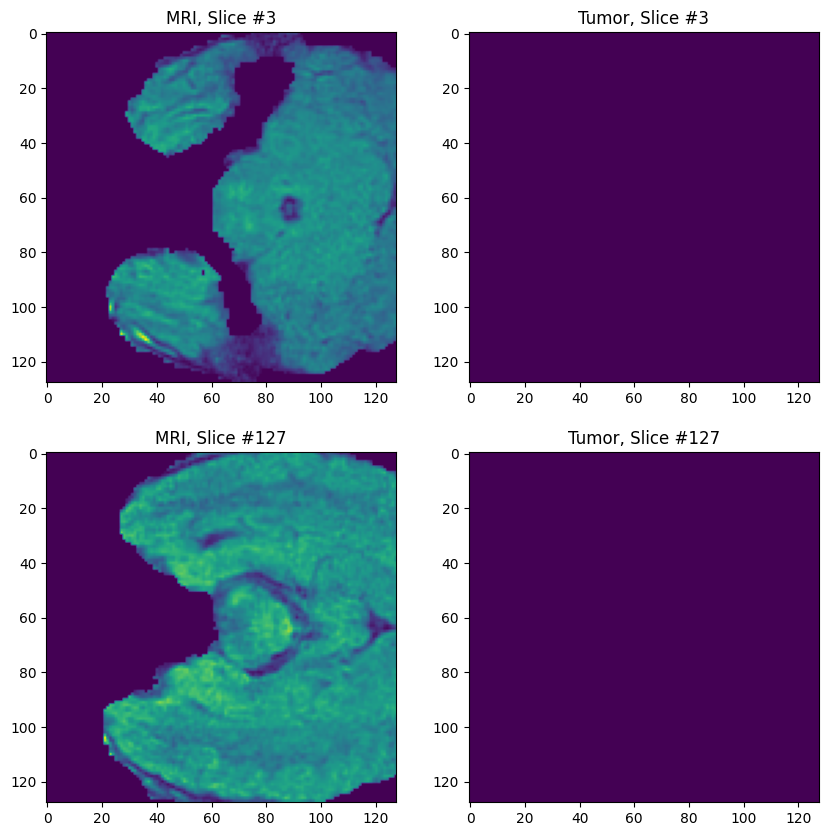

In [ ]:
training_data.plot_samples()

(128, 128, 128, 1)


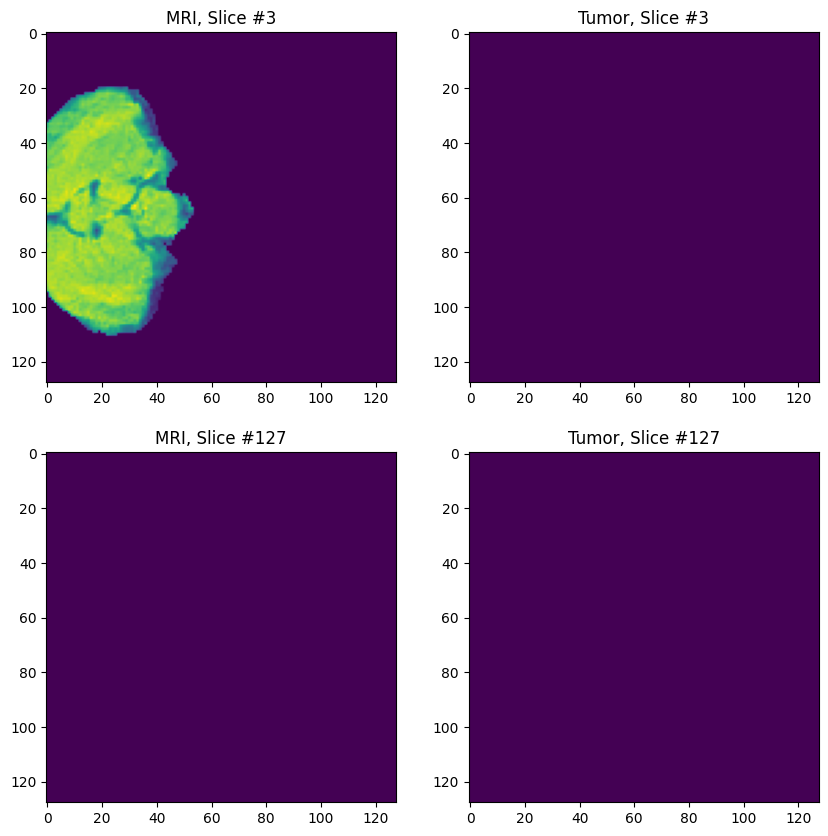

In [ ]:
data_validation.plot_samples()

(128, 128, 128, 1)


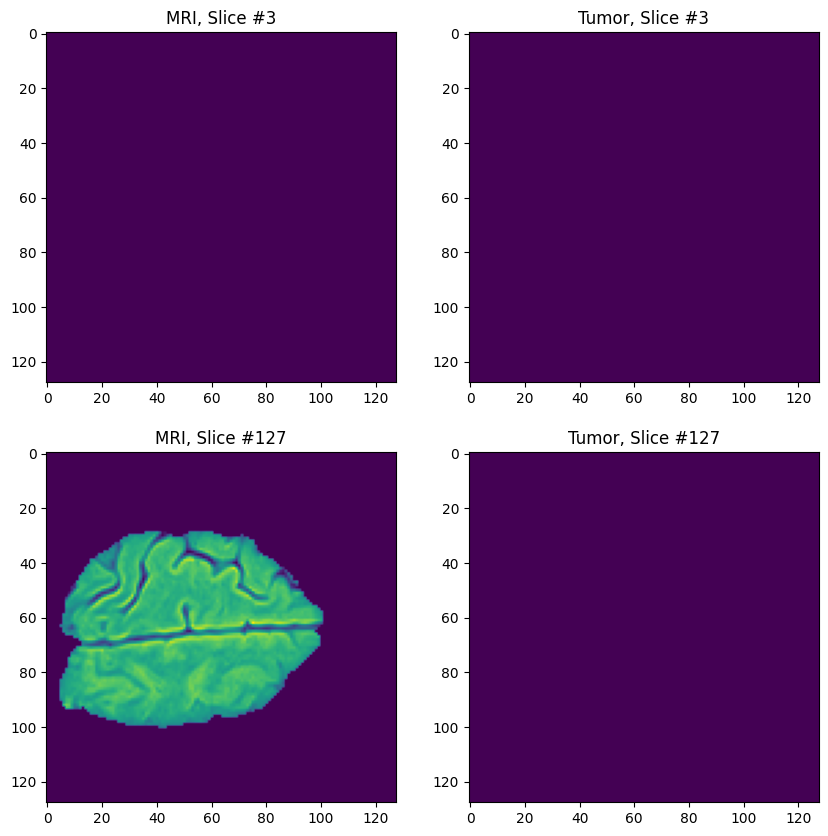

In [ ]:
testing_data.plot_samples()

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam

def unet_model(input_shape):
    # Define the input layer
    inputs = Input(input_shape)

    # Downward path (Encoder)
    conv1 = Conv2D(32, 3, activation='relu', padding='same')(inputs)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(64, 3, activation='relu', padding='same')(pool1)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(128, 3, activation='relu', padding='same')(pool2)
    conv3 = BatchNormalization()(conv3)

    # Upward path (Decoder)
    up4 = UpSampling2D(size=(2, 2))(conv3)
    up4 = Conv2D(64, 3, activation='relu', padding='same')(up4)
    up4 = BatchNormalization()(up4)
    up5 = UpSampling2D(size=(2, 2))(up4)
    up5 = Conv2D(32, 3, activation='relu', padding='same')(up5)
    up5 = BatchNormalization()(up5)

    # Output layer
    outputs = Conv2D(1, 1, activation='sigmoid')(up5)

    model = Model(inputs=inputs, outputs=outputs)
    return model

# Create and compile the model
model = unet_model(input_shape=(128, 128, 1))
model.compile(optimizer=Adam(lr=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()


Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 128, 128, 1)]     0         
                                                                 
 conv2d_18 (Conv2D)          (None, 128, 128, 32)      320       
                                                                 
 batch_normalization_15 (Ba  (None, 128, 128, 32)      128       
 tchNormalization)                                               
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 64, 64, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_19 (Conv2D)          (None, 64, 64, 64)        18496     
                                                                 
 batch_normalization_16 (Ba  (None, 64, 64, 64)        256 

In [ ]:
# Train for this number of iterations
number_of_epochs = 5

# Training the model with the resized labels, using validation data
history = model.fit(training_data, epochs=number_of_epochs, batch_size=batch_size, validation_data=data_validation, verbose=1)

Epoch 1/5
468/468 [==============================] - 543s 1s/step - loss: 0.2024 - accuracy: 0.9673 - val_loss: 0.0831 - val_accuracy: 0.9801
Epoch 2/5
468/468 [==============================] - 507s 1s/step - loss: 0.0521 - accuracy: 0.9840 - val_loss: 0.0449 - val_accuracy: 0.9842
Epoch 3/5
468/468 [==============================] - 512s 1s/step - loss: 0.0464 - accuracy: 0.9841 - val_loss: 0.0487 - val_accuracy: 0.9830
Epoch 4/5
468/468 [==============================] - 502s 1s/step - loss: 0.0410 - accuracy: 0.9854 - val_loss: 0.0446 - val_accuracy: 0.9834
Epoch 5/5
468/468 [==============================] - 507s 1s/step - loss: 0.0402 - accuracy: 0.9858 - val_loss: 0.0588 - val_accuracy: 0.9780


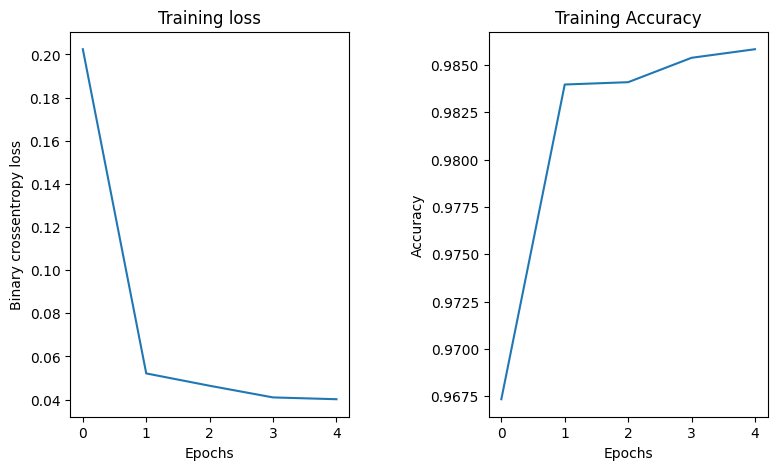

In [ ]:
import matplotlib.pyplot as plt
# Plotting training loss and accuracy

plt.figure(figsize=[9,5])
acc_curve_train=np.array(history.history['accuracy'])
loss_curve_train=np.array(history.history['loss'])

epochs=np.arange(loss_curve_train.shape[0])
plt.subplot(1,2,1)
plt.plot(epochs, loss_curve_train)
plt.xlabel('Epochs')
plt.ylabel('Binary crossentropy loss')
plt.title('Training loss')

plt.subplots_adjust(wspace=0.5)

plt.subplot(1,2,2)
plt.plot(epochs, acc_curve_train)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title("Training Accuracy")
plt.show()

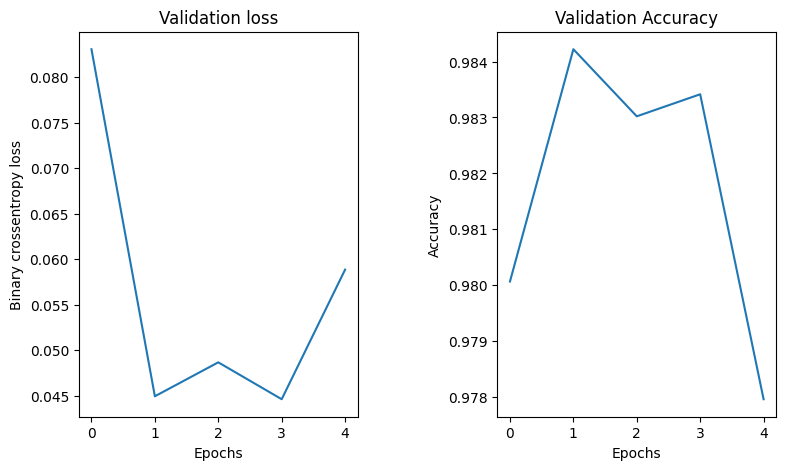

In [ ]:
# Plotting Validation loss and accuracy

plt.figure(figsize=[9,5])
acc_curve_validation=np.array(history.history['val_accuracy'])
loss_curve_validation=np.array(history.history['val_loss'])

epochs=np.arange(loss_curve_validation.shape[0])
plt.subplot(1,2,1)
plt.plot(epochs, loss_curve_validation)
plt.xlabel('Epochs')
plt.ylabel('Binary crossentropy loss')
plt.title('Validation loss')

plt.subplots_adjust(wspace=0.5)

plt.subplot(1,2,2)
plt.plot(epochs, acc_curve_validation)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title("Validation Accuracy")
plt.show()

In [ ]:
!pip install SimpleITK

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.7/52.7 MB 5.7 MB/s eta 0:00:00


In [ ]:
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import HTML, display

# Brain Tumor detection using 'JPG' images
# Loading a new sample JPG image for prediction
predict_image_jpg = io.imread('/content/drive/MyDrive/Brain_tumor_images/tumor1.jpg', as_gray=True)

# Assuming your model expects an input shape of (240, 155, 4, 1)
desired_height = 240
desired_width = 155
desired_depth = 4

# Preprocessing the new image similar to previous preprocessing steps
processed_new_image = transform.resize(predict_image_jpg, (desired_height, desired_width, desired_depth))
processed_new_image = np.expand_dims(processed_new_image, axis=-1)

# Making predictions using the trained model
predictions = model.predict(np.array([processed_new_image]))

# Applying thresholding to obtain binary mask (0: non-tumor, 1: tumor)
threshold = 0.5
binary_mask_jpg = (predictions > threshold).astype(int)

# Checking if any tumor pixels are present in the binary mask
tumor_detect = np.any(binary_mask_jpg == 1)

if tumor_detect:
    tumor_message = "<p style='color:red; font-weight:bold; font-size:32px;'>Tumor detected in the image.</p>"
else:
    tumor_message = "<p style='color:green; font-weight:bold; font-size:32px;'>No tumor detected in the image.</p>"

print("\n\n")
display(HTML(tumor_message))

# Displaying the original JPG image
plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 1)
plt.imshow(predict_image_jpg, cmap='gray')
plt.title('Original Image')

# Displaying the processed JPG image
plt.subplot(1, 3, 2)
plt.imshow(processed_new_image[:, :, processed_new_image.shape[2] // 2, 0], cmap='gray')
plt.title('Processed Image')


# Displaying the predicted JPG image
plt.subplot(1, 3, 3)
plt.imshow(binary_mask_jpg[0, :, :, binary_mask_jpg.shape[3] // 2, 0], cmap='gray')
plt.title('Predicted Image')

plt.show()

/content/drive/MyDrive/Brain_tumor_best_model/saved_model.pb

1/1 [==============================] - 0s 20ms/step





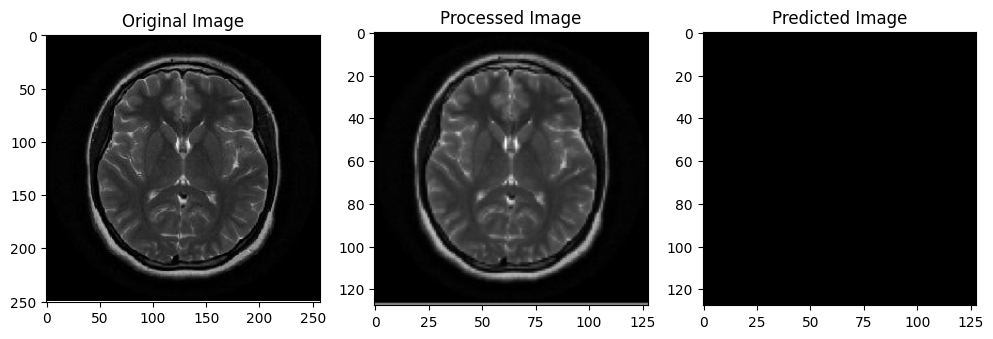

In [ ]:
# Load a new sample JPG image for prediction
predict_image_jpg = io.imread('/content/drive/MyDrive/Brain_tumor_images/Image_2.jpg', as_gray=True)

# Assuming your model expects an input shape of (128, 128, 1)
desired_height = 128
desired_width = 128

# Preprocess the new image
processed_new_image = transform.resize(predict_image_jpg, (desired_height, desired_width))
processed_new_image = np.expand_dims(processed_new_image, axis=-1)

# Making predictions using the trained model
predictions = model.predict(np.array([processed_new_image]))

# Applying thresholding to obtain binary mask (0: non-tumor, 1: tumor)
threshold = 0.5
binary_mask_jpg = (predictions > threshold).astype(int)

# Checking if any tumor pixels are present in the binary mask
tumor_detect = np.any(binary_mask_jpg == 1)

if tumor_detect:
    tumor_message = "<p style='color:red; font-weight:bold; font-size:32px;'>Tumor detected in the image.</p>"
else:
    tumor_message = "<p style='color:green; font-weight:bold; font-size:32px;'>No tumor detected in the image.</p>"

print("\n\n")
display(HTML(tumor_message))

# Displaying the original JPG image
plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
plt.imshow(predict_image_jpg, cmap='gray')
plt.title('Original Image')

# Displaying the processed JPG image
plt.subplot(1, 3, 2)
plt.imshow(processed_new_image[:, :, 0], cmap='gray')
plt.title('Processed Image')

# Displaying the predicted JPG image
plt.subplot(1, 3, 3)
plt.imshow(binary_mask_jpg[0, :, :, 0], cmap='gray')
plt.title('Predicted Image')
plt.show()